In [49]:

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



In [50]:
import pandas as pd
import numpy as np
import Quandl
from ggplot import *
% matplotlib inline
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# Define Mortgage Details: 

In [51]:
# Calculates monthly payment given number of months(n), loan amount(L), and the monthly interest rate (APY/12)
def calculate_montly_payment(n,L,monthly_interest):
    I = monthly_interest
    numerator = L*(1 + I)**n
    denomenator = -1*(1 - (1 + I)**n) / I
    return (numerator/denomenator)

In [52]:
# Mortgage
time = 15 # number of years for mortgage
interest = .03 # APY interest rate
price = 398000 # dollars
down_payment = .2 # percent/100
yearly_house_appreciation = .02 # percent appreciation of house value

# Taxes
marginal_tax_rate = .25 
expected_deduction = 6400 # expected standard deduction for current year
expected_deduction_yearly_increase = 100 # expected increase in standard deduction each year
property_tax = .01 # percent of house value payed as yearly property tax
long_term_capital_gains = .15

# Extra Costs
yearly_maintenance = .003 # percent of house value set aside yearly for repairs and maintenance
hoa_fee = 360 # montly hoa fee
hoa_yearly_increase = .01 # yearly percent increase in hoa fee
homeowner_insurance = 60 # monthly payment for insurance
homeowner_yearly_increase = .01 # yearly percent increase in insurance
closing_buy = .06 # percent of house value for closing cost when buying
closing_sell = .06 # percent of house value for closing cost when selling

#Rental Income
monthly_rent = 2200 # expected monthly rent for current year
rent_yearly_increase = .01 # yearly percent increase in rent
percent_vacancy = 1.0/12.0 # percent of the year with vacancy
rent_percent = 0.6 #percent of monthly rent as income, 0 means not renting, 1 means rental property

# Oportunity costs
investment_return = .05 #average yearly return
opportunity_rent = monthly_rent * (1 - rent_percent)

In [53]:
# For calculations: do not edit
n = time * 12 #number of months for the loan
L = price * (1.0 - down_payment) # loan amount
monthly_interest = interest/12.0 # monthly interest rate as a percent/100
p = calculate_montly_payment(n,L,monthly_interest) # monthly payment
print 'Monthly Payment = %.2f'%p

Monthly Payment = 2198.81


Key Assumptions:  
1. No capital gains when you sell your house (google for details)
2. House Value, HOA, Maintenance, Insurance, and Rent all increase/decrease by the same amount each year. Not a problem for long-term if good estimates.
3. You stick with one rental strategy.
4. Fixed Rate
5. No PMI
6. All gains on stocks are long term capital gains

# Calculate Cumulative Equity and Interest per month: 

In [54]:
mortgage = pd.DataFrame()
loan = L
month_list = range(1,n+1)
for month in month_list: # simulate monthly payment
    mortgage_month = pd.DataFrame()
    mortgage_month['Month'] = [month]
    mortgage_month['Loan_Before_Payment'] = loan
    loan = loan * (1+ monthly_interest) - p
    mortgage_month['Loan_After_Payment'] = loan
    mortgage_month['Equity_Gain'] = mortgage_month['Loan_Before_Payment'] - mortgage_month['Loan_After_Payment']
    mortgage = pd.concat([mortgage,mortgage_month])
mortgage['Interest_Paid'] = p - mortgage['Equity_Gain']
mortgage['Tax_Savings'] = mortgage['Interest_Paid'] * marginal_tax_rate
mortgage['Cumulative_Tax_Savings'] = mortgage['Tax_Savings'].cumsum()
mortgage['Year'] = np.ceil(mortgage['Month']/12.0)
mortgage['Cumulative_Equity_Gain'] = mortgage['Equity_Gain'].cumsum()
mortgage['Cumulative_Interest_Paid'] = mortgage['Interest_Paid'].cumsum()
mortgage['Total_Equity_With_Appreciation'] = (mortgage['Cumulative_Equity_Gain'] + down_payment * price) * (1 + yearly_house_appreciation)**mortgage['Year']
mortgage.set_index([range(len(mortgage))], inplace = True)

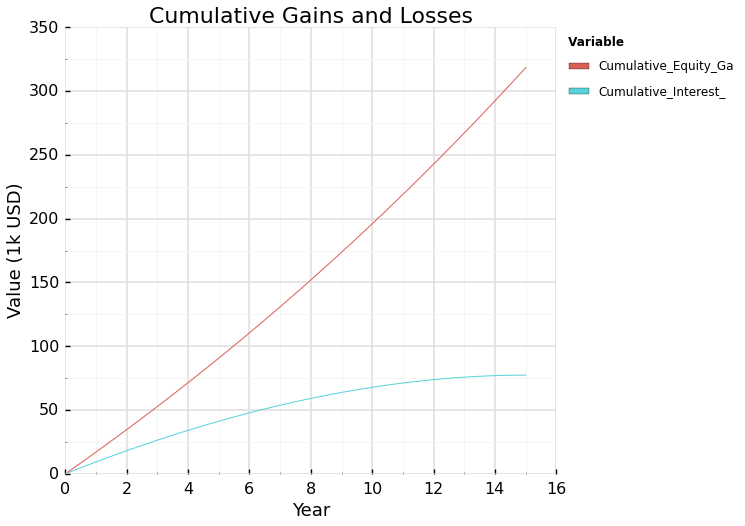

<ggplot: (33073580)>

In [55]:
plot_data = pd.melt(mortgage[['Month','Cumulative_Equity_Gain','Cumulative_Interest_Paid']], id_vars = ['Month'], value_vars = ['Cumulative_Equity_Gain','Cumulative_Interest_Paid'])
ggplot(aes(x = 'Month/12.0', y = 'value/1000', color = 'variable'), data = plot_data)\
+ geom_line()\
+ theme_seaborn(context = 'poster')\
+ xlab('Year')\
+ ylab('Value (1k USD)')\
+ ggtitle('Cumulative Gains and Losses')
 

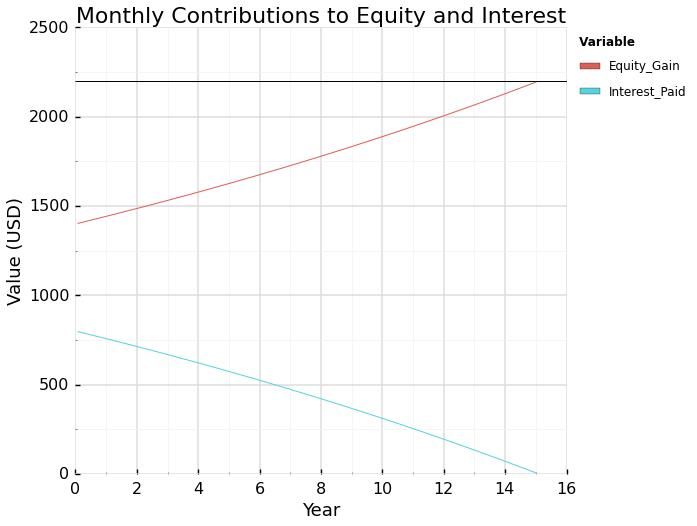

<ggplot: (32998467)>

In [56]:
plot_data_monthly = pd.melt(mortgage[['Month','Equity_Gain','Interest_Paid']], id_vars = ['Month'], value_vars = ['Equity_Gain','Interest_Paid'])
ggplot(aes(x = 'Month/12.0', y = 'value', color = 'variable'), data = plot_data_monthly)\
+ geom_line()\
+ geom_hline(yintercept = [np.round(p)], color = 'black')\
+ theme_seaborn(context = 'poster')\
+ xlab('Year')\
+ ylab('Value (USD)')\
+ ggtitle('Monthly Contributions to Equity and Interest')
 

# Yearly Info:

In [57]:
yearly_mortgage = mortgage[mortgage.Month%12 == 0] # Gives end of the year
yearly_mortgage = yearly_mortgage[['Year','Cumulative_Interest_Paid','Total_Equity_With_Appreciation','Cumulative_Tax_Savings']]

# House Appreciation
yearly_mortgage['House_Value'] = price * (1 + yearly_house_appreciation)**yearly_mortgage['Year']

# Taxes
yearly_mortgage['Property_Tax'] = property_tax * yearly_mortgage['House_Value']
yearly_mortgage['Cumulative_Property_Tax'] = yearly_mortgage['Property_Tax'].cumsum()
yearly_mortgage['Tax_Savings'] = yearly_mortgage['Cumulative_Tax_Savings']
yearly_mortgage['Tax_Savings'].iloc[1:len(yearly_mortgage)] = np.diff(yearly_mortgage['Cumulative_Tax_Savings'])
yearly_mortgage['Tax_Savings'] += marginal_tax_rate * yearly_mortgage['Property_Tax']
yearly_mortgage['Expected_Tax_Savings'] = (expected_deduction + expected_deduction_yearly_increase * mortgage['Year']) * (marginal_tax_rate) # Tax savings from standard dedecution
yearly_mortgage['Effective_Tax_Savings'] = yearly_mortgage['Tax_Savings'] - yearly_mortgage['Expected_Tax_Savings'] # Only count if savings above what you would get from standard deduction
yearly_mortgage['Effective_Tax_Savings'] = yearly_mortgage['Effective_Tax_Savings'].apply(lambda x: x if x > 0 else 0)
yearly_mortgage['Cumulative_Tax_Savings'] = yearly_mortgage['Effective_Tax_Savings'].cumsum()

# Total Costs
yearly_mortgage['HOA'] = 12 * hoa_fee * ((1 + hoa_yearly_increase) ** yearly_mortgage['Year'])
yearly_mortgage['Cumulative_HOA'] = yearly_mortgage['HOA'].cumsum()
yearly_mortgage['Homeowner_Insurance'] = 12 *homeowner_insurance * ((1 + homeowner_yearly_increase) ** yearly_mortgage['Year'])
yearly_mortgage['Cumulative_Homeowner_Insurance'] = yearly_mortgage['Homeowner_Insurance'].cumsum()
yearly_mortgage['Maintenance'] = yearly_maintenance * yearly_mortgage['House_Value']
yearly_mortgage['Cumulative_Maintenance'] = yearly_mortgage['Maintenance'].cumsum()
yearly_mortgage['Total_Cost'] = yearly_mortgage['Cumulative_Property_Tax'] \
+ yearly_mortgage['Cumulative_Interest_Paid']\
+ yearly_mortgage['Cumulative_HOA']\
+ yearly_mortgage['Cumulative_Homeowner_Insurance']\
+ yearly_mortgage['Cumulative_Maintenance']\
+ price * closing_buy\
+ yearly_mortgage['House_Value'] * closing_sell\


# Rental income
yearly_mortgage['Rent_Income'] = ((1-marginal_tax_rate) * (1 - percent_vacancy) * 12 * monthly_rent * rent_percent ) * ((1 + rent_yearly_increase) ** yearly_mortgage['Year'])
yearly_mortgage['Cumulative_Rent_Income'] = yearly_mortgage['Rent_Income'].cumsum()

# Summary
yearly_mortgage['Effective_Cost'] = yearly_mortgage['Total_Cost'] - yearly_mortgage['Cumulative_Rent_Income'] - yearly_mortgage['Cumulative_Tax_Savings']
yearly_mortgage['House_Net_Value'] = yearly_mortgage['Total_Equity_With_Appreciation'] - yearly_mortgage['Effective_Cost']

#Opportunity Cost
#yearly_mortgage['Effective_Yearly_Cost'] = yearly_mortgage['Effective_Cost'] - price * closing_buy - yearly_mortgage['House_Value'] * closing_sell #these are the recurring costs that could otherwise be invested
#yearly_mortgage['Effective_Yearly_Cost'].iloc[1:len(yearly_mortgage)] = np.diff(yearly_mortgage['Effective_Yearly_Cost'])

yearly_mortgage['Initial_Opportunity'] = ((down_payment+closing_buy)*price) * (1 + investment_return)**(yearly_mortgage['Year']) * (1-long_term_capital_gains) # investing the downpayment and the closing cost of buying
yearly_mortgage['Yearly_Rent_Cost'] = 12 * opportunity_rent * ((1 + rent_yearly_increase) ** yearly_mortgage['Year']) # The cost of renting

# Leftover money to invest if you choose to rent instead of buy, can be negative which means renting has opportunity cost
yearly_mortgage['Extra_Investing_Money'] = p * 12\
+ yearly_mortgage['HOA']\
+ yearly_mortgage['Property_Tax']\
+ yearly_mortgage['Homeowner_Insurance']\
+ yearly_mortgage['Maintenance']\
- yearly_mortgage['Rent_Income']\
- yearly_mortgage['Effective_Tax_Savings']\
- yearly_mortgage['Yearly_Rent_Cost']

#yearly_mortgage['Extra_Investing_Money'] = yearly_mortgage['Effective_Yearly_Cost'] - yearly_mortgage['Yearly_Rent_Cost'] # Leftover money to invest if you choose to rent instead of buy, it's fine if it is negative which means renting is costing you more


yearly_growth = np.array([])
for year in range(1,1 + time): #Take the extra investing money each year and invest it
    growth_years = yearly_mortgage[yearly_mortgage.Year <= year][['Year','Extra_Investing_Money']]
    growth_years['Years_Investing'] = np.array(growth_years.Year)[::-1] - 1 # The extra money is what you have at the end of the year, so at year 3, you would have invested the year 1 money for 2 years
    growth_years['Growth'] = growth_years['Extra_Investing_Money'] * (1 + investment_return) ** growth_years['Years_Investing']
    yearly_growth = np.append(yearly_growth,np.array([growth_years.Growth.sum()]))
    
yearly_mortgage['Total_Investment'] = yearly_growth * (1 - long_term_capital_gains)
yearly_mortgage['Rent_Net_Value'] = yearly_mortgage['Initial_Opportunity'] + yearly_mortgage['Total_Investment']
yearly_mortgage['Opportunity_Cost'] = yearly_mortgage['Rent_Net_Value'] - yearly_mortgage['House_Net_Value']

display_list = ['Year','Property_Tax','Effective_Tax_Savings','HOA','Homeowner_Insurance','Maintenance','Rent_Income','Rent_Net_Value','House_Net_Value']
yearly_mortgage[display_list]    

,Year,Property_Tax,Effective_Tax_Savings,HOA,Homeowner_Insurance,Maintenance,Rent_Income,Rent_Net_Value,House_Net_Value
11,1,4059.600000,1719.549067,4363.200000,727.200000,1217.880000,10998.900000,103720.038108,43394.862781
23,2,4140.792000,1585.068665,4406.832000,734.472000,1242.237600,11108.889000,120333.323773,56546.607566
35,3,4223.607840,1447.046889,4450.900320,741.816720,1267.082352,11219.977890,137843.815086,71376.459045
47,4,4308.079997,1305.371795,4495.409323,749.234887,1292.423999,11332.177669,156299.884992,87969.696387
59,5,4394.241597,1159.927952,4540.363416,756.727236,1318.272479,11445.499446,175752.445578,106415.856028
71,6,4482.126429,1010.596331,4585.767051,764.294508,1344.637929,11559.954440,196255.078674,126808.944632
83,7,4571.768957,857.254193,4631.624721,771.937454,1371.530687,11675.553984,217864.173097,149247.662767
95,8,4663.204336,699.774978,4677.940968,779.656828,1398.961301,11792.309524,240639.068869,173835.639823
107,9,4756.468423,538.028184,4724.720378,787.453396,1426.940527,11910.232620,264642.208752,200681.680739
119,10,4851.597792,371.879247,4771.967582,795.327930,1455.479337,12029.334946,289939.297488,229900.025145


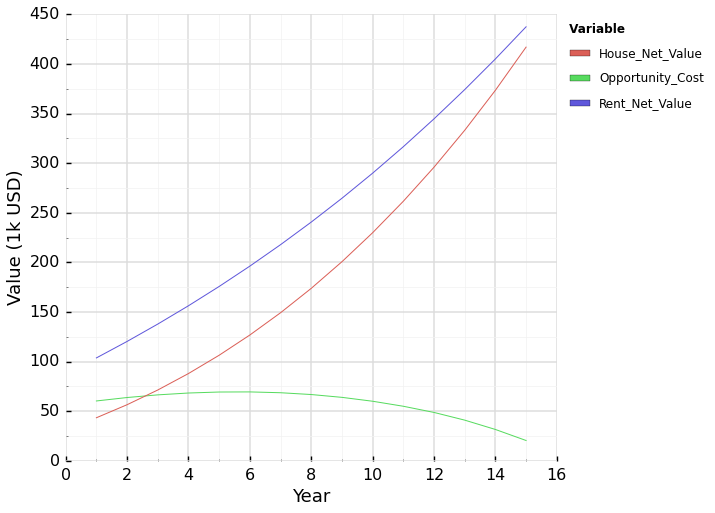

<ggplot: (33200388)>

In [58]:
total_plot = pd.melt(yearly_mortgage[['Year','House_Net_Value','Rent_Net_Value','Opportunity_Cost']], id_vars = ['Year'], value_vars = ['Opportunity_Cost','House_Net_Value','Rent_Net_Value'])
total_plot.set_index([range(len(total_plot))], inplace = True)
total_plot['value'] = np.round(total_plot['value'])
ggplot(aes(x = 'Year', y = 'value/1000', color = 'variable'), data = total_plot)\
+ geom_line()\
+ theme_seaborn(context = 'poster')\
+ ylab('Value (1k USD)')
#+ xlim(0,10)
 

**House_Net_Value**: This is the amount of money in your pocket after you live there for x years and sell it on year x.  
**Rent_Net_Value**: This is the amount of money you have after x years if you rent instead and invest your initial cost (downpayment and closing). You invest the lefover money you have saved from renting.

# Neighborhood 

In [59]:
zip_code = '92126'
num_bedrooms = '2'

In [60]:
index = Quandl.get('ZILL/Z%s_C'%zip_code)
bed = Quandl.get('ZILL/Z%s_%sB'%(zip_code,num_bedrooms))
sfl = Quandl.get('ZILL/Z%s_SFL'%zip_code)
prr = Quandl.get('ZILL/Z%s_PRR'%zip_code)
prr['Year'] = prr.index
index['Year'] = index.index
bed['Year'] = bed.index
sfl['Year'] = sfl.index

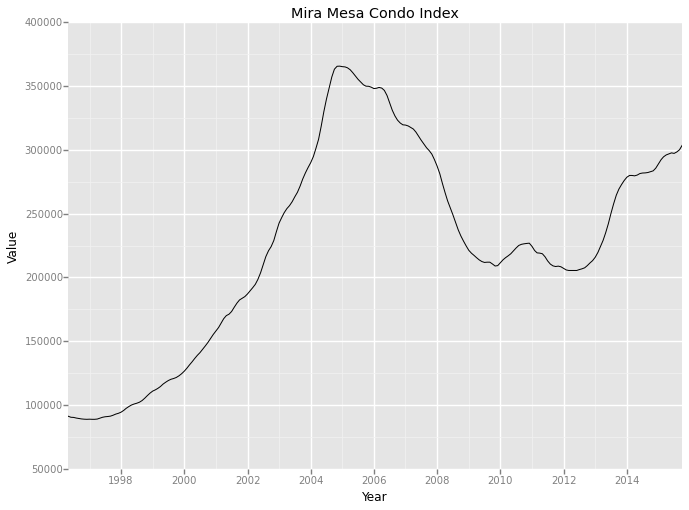

<ggplot: (33223754)>

In [61]:
ggplot(aes(x='Year', y = 'Value'), data = index)\
+ geom_line()\
+ ggtitle('Mira Mesa Condo Index')

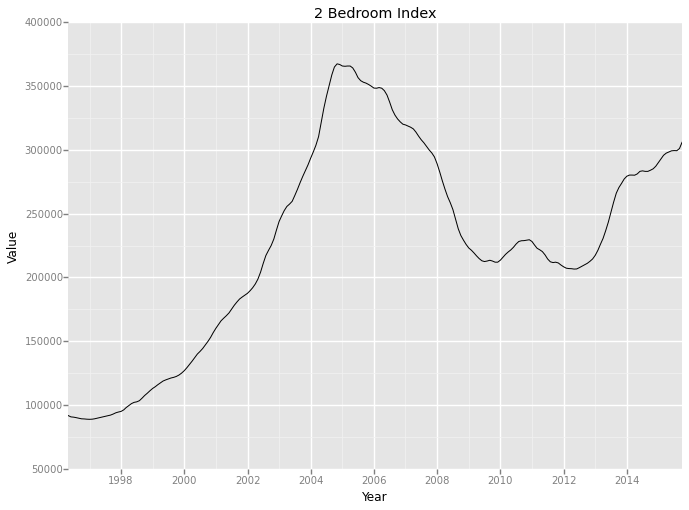

<ggplot: (2230767)>

In [62]:
ggplot(aes(x='Year', y = 'Value'), data = bed)\
+ geom_line()\
+ ggtitle('%s Bedroom Index'%num_bedrooms)

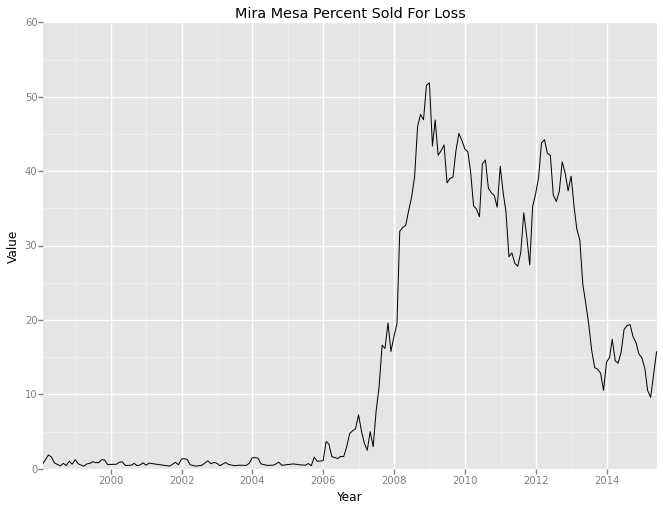

<ggplot: (34864293)>

In [63]:
ggplot(aes(x='Year', y = 'Value'), data = sfl)\
+ geom_line()\
+ ggtitle('Mira Mesa Percent Sold For Loss')

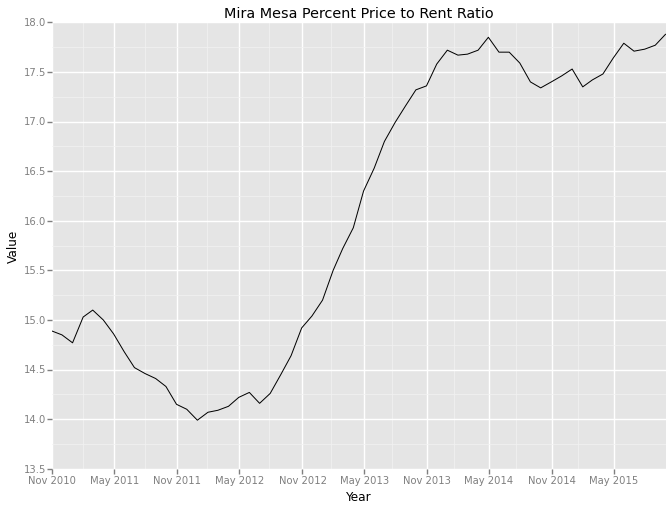

<ggplot: (33222723)>

In [64]:
ggplot(aes(x='Year', y = 'Value'), data = prr)\
+ geom_line()\
+ ggtitle('Mira Mesa Percent Price to Rent Ratio')